```bash
# Use different CUDA devices for each k value to parallelize execution
device=1
for k in 16 32 64 128 256; do
CUDA_VISIBLE_DEVICES=$device fusion_bench \
    path.log_dir="outputs/ViT-B-32/smile_upscaling/error_accumulation_analysis/${k}" \
    method=smile_upscaling/error_accumulation \
    method.k=$k \
    modelpool=CLIPVisionModelPool/clip-vit-base-patch32_TA8 &
device=$((device + 1))
done
wait  # Wait for all background processes to complete
```

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import CLIPVisionModel

from fusion_bench.constants import PROJECT_ROOT_PATH
from fusion_bench.constants.clip_vision import TASK_NAMES_TA8

sns.set_theme(style="whitegrid")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [35]:
results = {"k": [], "layer_idx": [], "error": [], "error_type": [], "task_name": []}


for k in [16, 32, 64, 128, 256]:
    output_dir = (
        PROJECT_ROOT_PATH
        / "outputs/ViT-B-32/smile_upscaling/error_accumulation_analysis"
        / str(k)
    )

    for task_name in TASK_NAMES_TA8:
        for layer_idx in range(12):
            finetuned_features = torch.load(
                output_dir / task_name / "finetuned" / f"layer_{layer_idx}.pth",
                map_location="cpu",
                weights_only=True,
            )
            smile_features = torch.load(
                output_dir / task_name / "smile" / f"layer_{layer_idx}.pth",
                map_location="cpu",
                weights_only=True,
            )
            low_rank_features = torch.load(
                output_dir / task_name / "low-rank" / f"layer_{layer_idx}.pth",
                map_location="cpu",
                weights_only=True,
            )

            smile_error = torch.mean(
                torch.norm(finetuned_features - smile_features, dim=1)
                / torch.norm(finetuned_features, dim=1)
            )
            results["k"].append(k)
            results["layer_idx"].append(layer_idx)
            results["error"].append(smile_error.item())
            results["error_type"].append("SMILE")
            results["task_name"].append(task_name)

            low_rank_error = torch.mean(
                torch.norm(finetuned_features - low_rank_features, dim=1)
                / torch.norm(finetuned_features, dim=1)
            )
            results["k"].append(k)
            results["layer_idx"].append(layer_idx)
            results["error"].append(low_rank_error.item())
            results["error_type"].append("Low-Rank")
            results["task_name"].append(task_name)

results = pd.DataFrame(results)
results.head()

,k,layer_idx,error,error_type,task_name
0,16,0,0.129942,SMILE,sun397
1,16,0,0.011223,Low-Rank,sun397
2,16,1,0.139189,SMILE,sun397
3,16,1,0.022879,Low-Rank,sun397
4,16,2,0.135666,SMILE,sun397


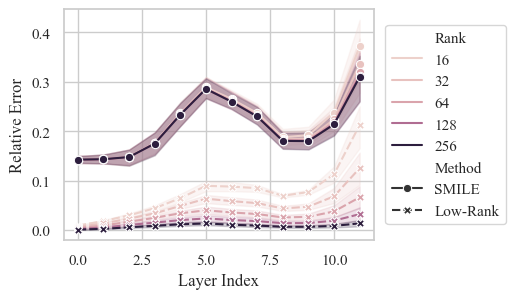

In [47]:
# Create a copy of the results with renamed column for plotting
plot_data = results.copy()
plot_data["Rank"] = plot_data["k"]
plot_data["Method"] = plot_data["error_type"]

fig, ax = plt.subplots(figsize=(4, 3))
sns.lineplot(
    data=plot_data,
    x="layer_idx",
    y="error",
    hue="Rank",
    style="Method",
    ax=ax,
    markers=True,
)

ax.set_xlabel("Layer Index")
ax.set_ylabel("Relative Error")

ax.legend(loc="right", bbox_to_anchor=(1.45, 0.5))

plt.savefig("error_accumulation_analysis.pdf", bbox_inches="tight")
plt.show()